In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import pandas as pd
import numpy as np
# from pacmagic_deeplearning.modeling.classifiers.bayesian.train_utils import make_performance_uncertainty_plot, cross_entropy


from utils import (get_weight_tensor_from_class_weights, 
                   train, plot_calibration_curve, make_precision_accuracy_plot,
                  make_performance_uncertainty_plot)
from utils import NNDropout

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score

In [3]:
X_train = pd.read_csv('../../data/MIMIC/X_train_processed.csv')
y_train = pd.read_csv('../../data/MIMIC/y_train.csv')

X_test = pd.read_csv('../../data/MIMIC/X_test_processed.csv')
y_test = pd.read_csv('../../data/MIMIC/y_test.csv')

In [4]:
data = torch.from_numpy(X_train.values).float()
target = torch.from_numpy(y_train.values).float()

data_val = torch.from_numpy(X_test.values).float()
target_val = torch.from_numpy(y_test.values).float()

In [5]:
canonical = NNDropout(quantiles=[0.5])
optimizer = torch.optim.Adam(canonical.parameters(), lr=1e-2)
canonical = train(canonical, data, target, data_val,
                 target_val, optimizer, quantiles=[0.5])

Validation loss: 0.33, Train loss: 0.32
Validation loss: 0.16, Train loss: 0.17
Validation loss: 0.12, Train loss: 0.09
Validation loss: 0.10, Train loss: 0.09
Validation loss: 0.11, Train loss: 0.09
Validation loss: 0.10, Train loss: 0.09
Validation loss: 0.10, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08


In [6]:
overconfident = NNDropout(quantiles=[0.4])

overconfident.z = canonical.z
overconfident.z.weight.requires_grad = False
overconfident.z.bias.requires_grad = False

optimizer = torch.optim.Adam(overconfident.parameters(), lr=1e-2)

overconfident = train(overconfident, data, target, 
             data_val, target_val, optimizer, quantiles=[0.4])

Validation loss: 0.26, Train loss: 0.30
Validation loss: 0.18, Train loss: 0.17
Validation loss: 0.13, Train loss: 0.10
Validation loss: 0.12, Train loss: 0.09
Validation loss: 0.10, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09
Validation loss: 0.09, Train loss: 0.09


In [7]:
underconfident = NNDropout(quantiles=[0.6])

underconfident.z = canonical.z
underconfident.z.weight.requires_grad = False
underconfident.z.bias.requires_grad = False

optimizer = torch.optim.Adam(underconfident.parameters(), lr=1e-2)

underconfident = train(underconfident, data, target, 
             data_val, target_val, optimizer, [0.6])

Validation loss: 0.42, Train loss: 0.42
Validation loss: 0.24, Train loss: 0.24
Validation loss: 0.12, Train loss: 0.10
Validation loss: 0.11, Train loss: 0.08
Validation loss: 0.09, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08
Validation loss: 0.08, Train loss: 0.08


In [8]:
outputs_val = [underconfident(data_val)[0], canonical(data_val)[0], overconfident(data_val)[0]]

In [9]:
outputs = [torch.sigmoid(output) for output in outputs_val]

In [10]:
plots = []

for output in outputs:
    plots.append(plot_calibration_curve(y_test, output.detach().numpy()))

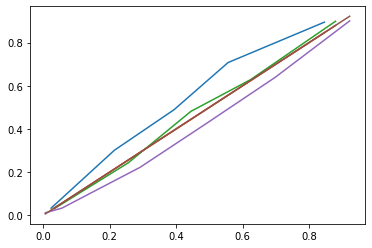

In [11]:
for plot in plots:
    plt.plot(plot[0], plot[1])
    plt.plot(plot[0], plot[0])
    
plt.show()

In [12]:
outputs_val = torch.stack([torch.sigmoid(output_val.squeeze()) for output_val in outputs_val], dim=1).detach().numpy().round(3)

In [13]:
# optimal cutoff point
cutoff = np.percentile(outputs_val[:, 1], 100 * (1-y_train.values.mean()))
cutoff

0.29851901240385764

In [14]:
preds = (outputs_val > cutoff)

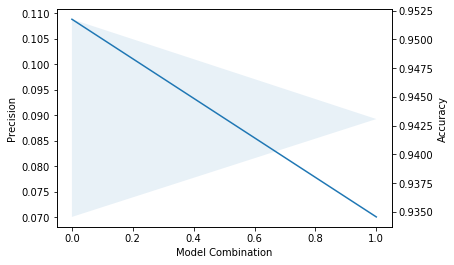

In [15]:
make_precision_accuracy_plot(outputs_val, preds, y_test)

Text(0, 0.5, 'Uncertainty')

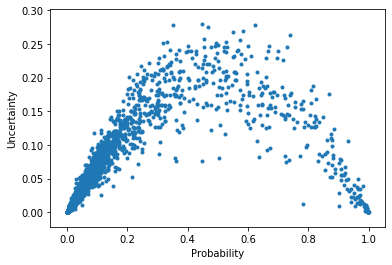

In [16]:
# uncertainties = np.std(outputs_val[:, 1:9], axis=-1)
# uncertainties = outputs_val[:, 1] - outputs_val[:, 9]
# uncertainties = outputs_val[:, 2] - outputs_val[:, 8]
# uncertainties = outputs_val[:, 3] - outputs_val[:, 7]
uncertainties = outputs_val[:, 2] - outputs_val[:, 0]

preds_50 = preds[:, 1]
# plt.scatter(outputs_val[:, 5][preds_50 == y_test.squeeze().values], uncertainties[preds_50 == y_test.squeeze().values], marker='.')
# plt.scatter(outputs_val[:, 5][preds_50 != y_test.squeeze().values], uncertainties[preds_50 != y_test.squeeze().values], marker='.')
plt.scatter(outputs_val[:, 1], uncertainties, marker='.')
plt.xlabel('Probability')
plt.ylabel('Uncertainty')


In [17]:
y_true = y_test.values.squeeze(-1)
y_prob = outputs_val[:, 1]
y_unc = uncertainties

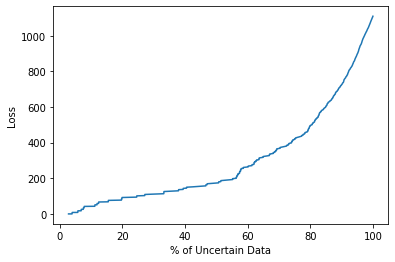

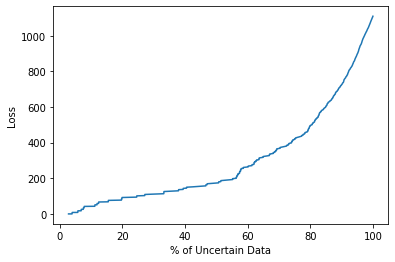

In [18]:
from utils import make_performance_uncertainty_plot

make_performance_uncertainty_plot(y_true, y_prob, y_unc, 'Loss', performance_fn_args={'reduction': 'sum'})

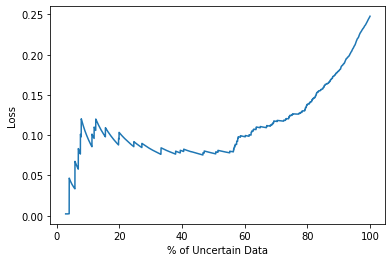

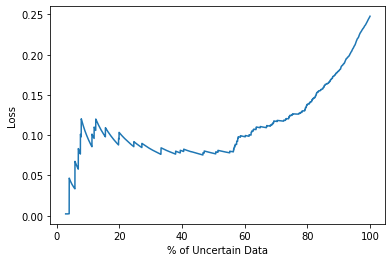

In [19]:
make_performance_uncertainty_plot(y_true, y_prob, y_unc, 'Loss', performance_fn_args={'reduction': 'mean'})

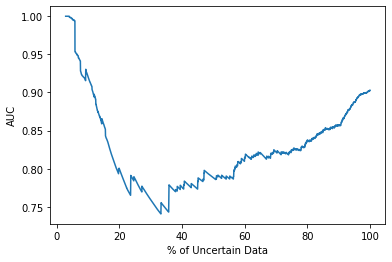

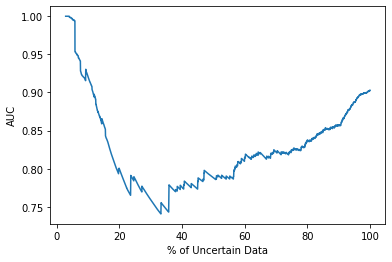

In [20]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'AUC', performance_fn=roc_auc_score)

In [24]:
from utils import loss_at_50, cross_entropy

In [25]:
loss_at_50(y_true, y_prob, uncertainties)

173.59004501521122

In [27]:
cross_entropy(y_true, y_prob, reduction='sum')

1109.9093702592654

In [28]:
false_predictions = preds_50 != y_test.squeeze()

In [29]:
roc_auc_score(false_predictions, uncertainties)

0.8606449728854927

In [30]:
average_precision_score(false_predictions, uncertainties)

0.3619878598589782

## Asymmetric entropy baseline

In [31]:
def asymmetric_entropy(p, w):
    return (p * (1 - p)) / ((-2 * w + 1) * p + w ** 2)


In [32]:
# uncertainties = asymmetric_entropy(outputs_val[:, 5], y_train.values.mean())
uncertainties = asymmetric_entropy(outputs_val[:, 1], cutoff)

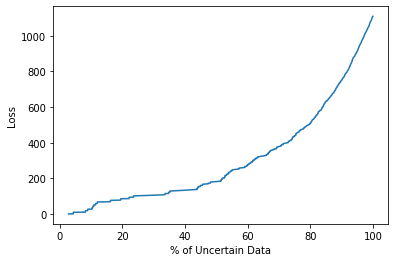

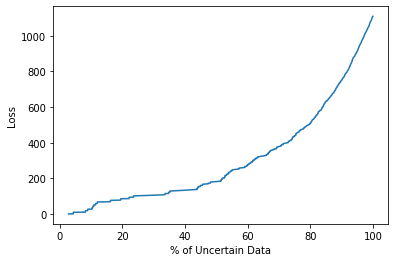

In [33]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'Loss', performance_fn_args={'reduction': 'sum'})

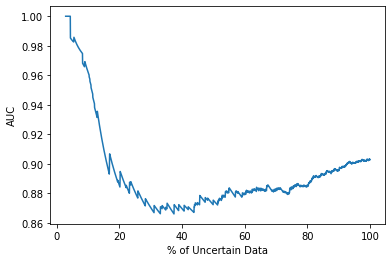

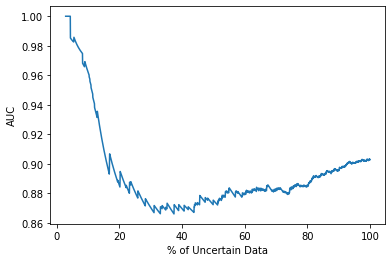

In [34]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'AUC', performance_fn=roc_auc_score)

In [35]:
loss_at_50(y_true, y_prob, uncertainties)

181.85163835145067

In [36]:
roc_auc_score(false_predictions, uncertainties)

0.8487880859311272

In [37]:
average_precision_score(false_predictions, uncertainties)

0.3214530374440751